In [8]:
import numpy as np
import math
from typing import Tuple

def min_resolvable_angles_rc(rows: int,
                             cols: int,
                             d_over_lambda: float = 0.5,
                             factor: float = 0.5
                            ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Estimate minimal resolvable angle (per dimension) for an Rx/Tx rectangular array
    using the rule-of-thumb: min_separation ≈ factor * HPBW.

    Returns:
      (az, el): each is a NumPy array [min_rad, min_deg, HPBW_rad, HPBW_deg]
    """
    if rows < 1 or cols < 1:
        raise ValueError("rows and cols must be >= 1")

    # HPBW ~ 1.77/N for d = λ/2. For other spacings, mainlobe scales ~ (0.5 / d_over_lambda).
    scale = 0.5 / d_over_lambda
    hpbw_az_rad = (1.77 / cols) * scale
    hpbw_el_rad = (1.77 / rows) * scale

    min_az_rad = factor * hpbw_az_rad
    min_el_rad = factor * hpbw_el_rad

    # Convert to degrees
    rad2deg = 180.0 / math.pi
    az = np.array([min_az_rad, min_az_rad * rad2deg, hpbw_az_rad, hpbw_az_rad * rad2deg])
    el = np.array([min_el_rad, min_el_rad * rad2deg, hpbw_el_rad, hpbw_el_rad * rad2deg])

    return az, el

# Example:
az, el = min_resolvable_angles_rc(16, 16)
print("Azimuth [min_rad, min_deg, HPBW_rad, HPBW_deg]:", az)
print("Elevation [min_rad, min_deg, HPBW_rad, HPBW_deg]:", el)
print(np.tan(az[0])*550, "km")

Azimuth [min_rad, min_deg, HPBW_rad, HPBW_deg]: [0.0553125  3.1691728  0.110625   6.33834561]
Elevation [min_rad, min_deg, HPBW_rad, HPBW_deg]: [0.0553125  3.1691728  0.110625   6.33834561]
30.45293797999386 km


In [1]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 50  #  75 W- 100W 48.75-50.00 dBm
jam_power_dbm = 60
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
Jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

N0 = noise_power_watt

T_sys = 300.0  # K  realistic mid-value for LEO sat RX
N0 = 1.38e-23 * 100e6 * T_sys*La_linear
P0 = Tx_power_watt
P1 = Jam_power_watt


In [2]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from minmax_solvers import (
    solve_game_bestresp_Q0_then_Q1,
    compute_J
)
from CloseBF import jammeraware_Q
from Dishjammersolver import optimal_Q0
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray
from numpy.linalg import cholesky, solve, eigh


# Generate RX positions
jam_dist = 15
# distances_km = [5,15,10,20]
# distances_km = [jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist]
distances_km = [jam_dist,jam_dist,jam_dist,jam_dist]
# distances_km = [jam_dist,jam_dist,jam_dist]
# distances_km = [jam_dist]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

sat_orbit_m = 550e3
# angles = [(117.88, 56.2),(230.22, 72.96), (198,60.5),(345.49,65.65), (272.81, 60.03)]
# angles = [(1, 90-(1e-9))]
angles = [(45, 90-(1e-3)), (120, 87), (75,85),(80,83), (65, 82),(130,80)]
# angles = [(45, 90-(1e-3)), (220, 87), (75,85)]
sat_positions = []
delays_ms = []
fspl_db = []
frequency_hz = 10e9 
wavelength = 3e8 / frequency_hz

for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    sat_positions.append(pos)
    delays_ms.append(delay)
    fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
    fspl_db.append(fspl)

sat_positions = np.array(sat_positions)
delays_ms = np.array(delays_ms)
fspl_db = np.array(fspl_db)

print("\nSatellite Pos [m]:\n", sat_positions)
# print("\nPropagation delays [ms]:\n", delays_ms)
# print("\nFree-space path loss [dB]:\n", fspl_db)


# Compute az/el/dist per TX-SAT
  
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


jitc_llvm_init(): LLVM API initialization failed ..


ImportError: jit_init_thread_state(): the LLVM backend is inactive because the LLVM shared library ("libLLVM.so") could not be found! Set the DRJIT_LIBLLVM_PATH environment variable to specify its path.

In [24]:
from sionna.rt import Scene, Receiver, Transmitter, PlanarArray, PathSolver, load_scene, RadioMapSolver
import vsat_dish_3gpp
def compute_cir(tx_pos, rx_pos, tx_array, rx_array, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = load_scene()
    scene.frequency = frequency
    scene.synthetic_array = True
    
    
    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
        
        
    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos)
    scene.add(tx)

    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    # earth_radius_m = 6371e3
    # rx_look_at = np.array([0.0, 0.0, -1*earth_radius_m/2])
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(tx)
        rx_list.append(rx)
    # tx_look_at2 = np.array(tx_pos) + np.array([0.0, 0.0, 100.0])
    tx.look_at( np.array([0,0,1]))  # Point TX to the first RX

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                   seed=41)

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")


    
    return a_all, tau_all, scene


jam_rows = 1
jam_cols = 1
jam_antennas = jam_cols*jam_rows

sat_rows = 8
sat_cols = 8
sat_antennas = sat_cols*sat_rows

tx_rows = 8
tx_cols = 8
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                            pattern="vsat_dish",
                            # pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="tr38901",
                            # pattern="iso",
                             polarization="V")

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t

a_tx, tau_tx,scene_tx = compute_cir(sat_positions[0],gnd_positions[0,:].reshape(1,-1), sat_array,tx_array)
a_jam, tau_jam,scene_jam = compute_cir(sat_positions[0], gnd_positions[1:,:], sat_array,jam_array)
H_tx = collapse_channel(a_tx)
H_jam = collapse_channel(a_jam)


In [31]:
# from BeamformingCalc import svd_bf, nulling_bf,left_singular_u1, nulling_bf_fast_scipy
from typing import Tuple
def svd_bf(H: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    SVD beamforming for y = H x + n with H shape (Nr, Nt).
    Returns:
        w_t: (Nt, 1) principal right singular vector (transmit beam)
        w_r: (Nr, 1) principal left  singular vector (receive combiner)
    """
    if H.ndim != 2:
        raise ValueError("H must be 2D (Nr x Nt)")
    Nr, Nt = H.shape
    # SVD: H = U Σ Vh, where U:(Nr,Nr), Vh:(Nt,Nt)
    U, s, Vh = np.linalg.svd(H, full_matrices=False)
    v1 = Vh.conj().T[:, 0].reshape(Nt, 1)  # (Nt,1)
    u1 = U[:, 0].reshape(Nr, 1)            # (Nr,1)
    # ensure unit-norm (guard against numerical drift)
    v1 = v1 / (np.linalg.norm(v1) + 1e-15)
    u1 = u1 / (np.linalg.norm(u1) + 1e-15)
    return v1, u1  # (w_t, w_r)


def nulling_bf(h: np.ndarray, 
               w_r: np.ndarray, 
               interference_term: np.ndarray, 
               lambda_: float,):
    """
    Calculates the nulling vector v_null based on the interference covariance.

    The nulling vector is the principal eigenvector of 
    Q = h * w_r * w_r^H * h^H - lambda_ * interference_term.

    Parameters
    ----------
    h : np.ndarray
        The channel matrix of shape (num_tx_antennas, num_rx_antennas). 
        Must be compatible with w_r (i.e., h.shape[1] == w_r.shape[0]).
    w_t : np.ndarray
        The transmitte beamforming vector, of shape (num_tx_antennas, 1).
    interference_term : np.ndarray
        The aggregated interference covariance matrix, typically shape (num_tx_antennas, num_tx_antennas).
    lambda_ : float
        A weighting factor that balances the desired signal versus the interference penalty.

    Returns
    -------
    v_null : np.ndarray
        The nulling vector, of shape (num_rx_antennas, 1),
        which is used on the transmit side (or receive side, depending on your convention)
        to mitigate interference.
    """
    
    # h= ((h)*np.sqrt(tx_antennas)  /np.linalg.norm(h))
    # h = ((h) /np.linalg.norm(h))
    # interference_term = (interference_term) /np.linalg.norm(interference_term)
    # Build the matrix Q
    A = h @ w_r @ w_r.conj().T @ h.conj().T
    # interference_term= hermitize(interference_term)
    B = lambda_ * interference_term
    Q = A-B
    Q = 0.5 * (Q + Q.conj().T)
    # Q = h @ w_r @ w_r.conj().T @ h.conj().T - lambda_ * interference_term
    
    # Eigen-decomposition of Q
    eigen_values, v_nulls = np.linalg.eigh(Q)

    # Sort eigenvalues from largest to smallest
    idx = np.argsort(eigen_values)[::-1]
    eigen_values_sorted = eigen_values[idx]
    max_eigen_value = eigen_values_sorted[0]
    v_nulls = v_nulls[:, idx]
    # The nulling vector is the eigenvector corresponding to the largest eigenvalue
    v_null = v_nulls[:, 0].reshape(-1, 1)
    
    return v_null, A, B, max_eigen_value


lambda_ = 200
interference_term = H_jam.conj().T@H_jam
_, w_rx = svd_bf(H_tx)
w_null,_,_,_ = nulling_bf(H_tx.T,w_rx,interference_term,lambda_)

def channel_capacity_multi_jammers(H_sig,w_t, w_r, P0, H_jams, P1,N0):

    H_sig = H_sig.T
    g_sig = (w_r.conj().T @ H_sig @ w_t)
    S = (np.abs(g_sig) ** 2) * (P0)
    I_total = 0
    H_jams = H_jams.T
    for i in range (H_jams.shape[1]):
        hjam = H_jams[:,i].reshape(-1, 1)
        I_total += (np.abs((w_r.conj().T @ hjam)) ** 2) *(P1)
    denom = I_total+N0
    sinr = (S / denom)
    sinr_db = 10*np.log10(sinr).item()
    inr_db = 10*np.log10(I_total/N0).item()
    C = np.log2(1.0 + sinr).item()

    return C, sinr_db, inr_db

C, sinr, inr_db = channel_capacity_multi_jammers( H_sig=H_tx,w_t=w_rx,w_r=w_null,P0=P0,H_jams=H_jam, P1=P1,  N0=N0)

print("Capacity [bit/s/Hz] =", C)
print("SINR (db)       =", sinr)
print("inr(db)       =", inr_db)

# from Dishjammersolver import optimal_Q0


# Q0, Q1, _, C_water = optimal_Q0( H_tx.T, H_jam.T, N0, P0, P1)
# print("Capacity [bit/s/Hz] =", C_water)
# print(np.linalg.matrix_rank(Q0))

Capacity [bit/s/Hz] = 0.1396208256483078
SINR (db)       = -9.930399656295776
inr(db)       = -8.341568112373352


In [32]:
# import numpy as np

# def uplink_max_sinr_at_sat(H_tx, H_jam, P0, P1, N0, ridge=1e-9):
#     """
#     Max-SINR for uplink (ground->sat). Shapes kept:
#       H_tx  : (Nr, Ntx)  (downlink sat->ground; uplink uses H_ul = H_tx^H)
#       H_jam : (J,  Ntx)  rows = jammer steering at the satellite array
#       P1    : scalar or (J,) jammer powers
#     Returns:
#       w_t_gnd : (Nr,1)  ground Tx beam (unit-norm)
#       w_r_sat : (Ntx,1) satellite Rx beam (unit-norm, MVDR)
#       sinr_lin, sinr_db, C_bps_per_Hz
#     """
#     H  = np.asarray(H_tx,  dtype=complex)    # (Nr,Ntx)
#     Hj = np.asarray(H_jam, dtype=complex)    # (J,Ntx)
#     Nr, Ntx = H.shape
#     J = Hj.shape[0]

#     # p = np.asarray(P1).flatten()
#     # if p.size == 1: p = np.full(J, (p))
    
#     p = np.asarray(P1).flatten()
#     if p.size == 1:
#         p = np.full(J, float(p[0]))
#     elif p.size != J:
#       raise ValueError(...)
#     elif p.size != J: raise ValueError(f"P1 length {p.size} must equal J={J} or be scalar.")
#     if np.any(p < 0): raise ValueError("P1 must be nonnegative.")

#     # R_sat = Hj^H diag(P1) Hj + N0 I
#     Hj_w  = (np.sqrt(p).reshape(-1,1)) * Hj
#     R_sat = Hj_w.conj().T @ Hj_w + N0*np.eye(Ntx)
#     R_sat = 0.5*(R_sat + R_sat.conj().T) + ridge*np.eye(Ntx)

#     # G_gnd = H_tx R_sat^{-1} H_tx^H (Nr x Nr)
#     RinvtH = np.linalg.solve(R_sat, H.conj().T)   # (Ntx,Nr)
#     G_gnd  = H @ RinvtH                           # (Nr,Nr)
#     G_gnd  = 0.5*(G_gnd + G_gnd.conj().T)

#     # Ground Tx beam = principal eigenvector of G_gnd
#     evals, evecs = np.linalg.eigh(G_gnd)
#     i = int(np.argmax(evals))
#     w_t_gnd = evecs[:, i:i+1]
#     w_t_gnd/= (np.linalg.norm(w_t_gnd) + 1e-15)

#     # Satellite Rx beam (MVDR/MMSE direction)
#     H_ul = H.conj().T
#     s    = H_ul @ w_t_gnd
#     v    = np.linalg.solve(R_sat, s)
#     w_r_sat = v / (np.linalg.norm(v) + 1e-15)

#     sinr_lin = (P0 * np.vdot(s, np.linalg.solve(R_sat, s)).real)  # P0*s^H R^{-1}s
#     sinr_db  = 10*np.log10(max(sinr_lin, 1e-300))
#     C        = np.log2(1.0 + sinr_lin)
#     return w_t_gnd, w_r_sat, sinr_lin, sinr_db, C



# w_t_gnd, w_r_sat, sinr_lin, sinr_db, C_maxsinr = uplink_max_sinr_at_sat(H_tx, H_jam, P0, P1, N0, ridge=1e-9)
# print("SINR (db)", sinr_db)
# print("Capacity [bit/s/Hz]", C_maxsinr)

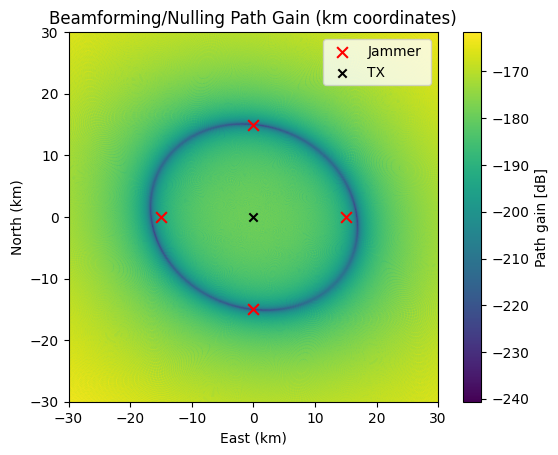

In [33]:
import matplotlib.pyplot as plt
import mitsuba as mi

scene = load_scene()
scene.frequency = fc
scene.synthetic_array = True

for tx_name in scene.transmitters:
    scene.remove(tx_name)
for rx_name in scene.receivers:
    scene.remove(rx_name) 
    
# Add transmitter
scene.tx_array = sat_array
groundpos = sat_positions[0]
# groundpos = np.array([0,0,500e3])
tx = Transmitter(name="tx", position=groundpos)
scene.add(tx)
tx.look_at( np.array([0,0,1]))  # Point TX to the first RX
# w_null2 = w_null.conj().T
w_null2 = w_null
precoding_vec_real = mi.TensorXf(w_null2.real)
precoding_vec_imag = mi.TensorXf(w_null2.imag)
# precoding_vec_real = mi.TensorXf(w_null2.imag)
# precoding_vec_imag = mi.TensorXf(w_null2.real)
precoding_vec = (precoding_vec_real, 
                 precoding_vec_imag)
rm_solver = RadioMapSolver()

rm = rm_solver(scene,
               max_depth=0,           # Maximum number of ray scene interactions
               samples_per_tx=10**9 , # If you increase: less noise, but more memory required
               precoding_vec=precoding_vec,
               cell_size=(100, 100),      # Resolution of the radio map
               center=[0, 0, 1],      # Center of the radio map
               size=[60e3, 60e3],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical

fig = rm.show(metric="path_gain")
ax  = fig.axes[0]

# === km ===
Lx, Ly = 60e3, 60e3     
im = ax.images[0]
extent_km = [-Lx/2/1e3, Lx/2/1e3, -Ly/2/1e3, Ly/2/1e3]
im.set_extent(extent_km)
ax.set_xlim(extent_km[0], extent_km[1])
ax.set_ylim(extent_km[2], extent_km[3])
ax.set_xlabel("East (km)")
ax.set_ylabel("North (km)")
jam_xy_km = gnd_positions[1:, :2] / 1e3
ax.scatter(jam_xy_km[:,0], jam_xy_km[:,1],
           c='red', s=60, marker='x', label='Jammer ')
ax.scatter(gnd_positions[0,1], gnd_positions[0,2], marker='x', color='black',  label='TX')

ax.legend()
ax.set_title("Beamforming/Nulling Path Gain (km coordinates)")
plt.show()
